# Librerias

In [1]:
### Importación de librerias
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, OrdinalEncoder


# graficas
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


# Preparación de datos

In [2]:
data = pd.read_excel('../data/Base_infecciones_POPTH_nuevo_modelado.xlsx')

In [3]:
data

,Código anonimizado,#Paciente_Tx,Etiología_#1,Etiología_#2,Edad,Sexo,Child_Pugh_Score_Cat,Child_Pugh_Score,Meld_Score,Diabetes_Mellitus,...,Fecha_Egreso_Hospitalario,Requerimiento_de_diálisis,Trasfusión_GRE_hasta_1m_POP,Reintervención_Quirúrgica_hasta_1m_POP,Retrasplante,Vivo_Hoy,Fecha_Control/Muerte,SOBREVIDA_DIAS,SOBREVIDA_MESES,SOBREVIDA_AÑOS
0,P001,1,HCV,NINGUNA,62,M,NaN,-1,18,NO,...,2009-01-13,NO,NO,SI,NO,NO,2009-10-05,275,9.17,0.76
1,P002,2,NASH,NINGUNA,62,M,NaN,-1,17,NO,...,2009-01-11,NO,NO,SI,NO,NO,2009-01-11,1,0.03,0.00
2,P003,3,HEPATITIS AUTOINMNE,NINGUNA,56,F,NaN,-1,15,NO,...,2009-02-16,NO,NO,NO,NO,SI,2023-12-31,5444,181.47,15.12
3,P004,4,NASH,NINGUNA,58,M,NaN,-1,9,NO,...,2009-02-14,NO,NO,NO,NO,SI,2023-12-31,5442,181.40,15.12
4,P005,5,ALCOHÓLICA,NINGUNA,62,F,NaN,-1,22,SI,...,2009-02-18,NO,NO,NO,NO,SI,2023-12-31,4724,157.47,13.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,P553,553,CRIPTOGENICA,NINGUNA,22,M,C,11,22,NO,...,2024-09-27,NO,NO,NO,NO,SI,2024-09-21,0,0.00,0.00
553,P554,554,HEPATITIS AUTOINMNE,NINGUNA,33,F,C,10,21,NO,...,NaT,SI,SI,DESCONOCIDO,DESCONOCIDO,NO,2025-03-31,174,5.00,0.00
554,P555,555,NASH,ALCOHÓLICA,55,M,B,9,20,SI,...,2024-10-12,NO,NO,NO,NO,SI,2025-05-07,203,6.00,0.00
555,P556,556,CIRROSIS HEPATICA POR COLANGIOPATÍA AUTOINMUNE,NINGUNA,54,F,B,9,14,NO,...,2024-10-25,NO,NO,NO,NO,SI,2025-05-13,196,6.00,0.00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 62 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Código anonimizado                          557 non-null    object        
 1   #Paciente_Tx                                557 non-null    int64         
 2   Etiología_#1                                557 non-null    object        
 3   Etiología_#2                                557 non-null    object        
 4   Edad                                        557 non-null    int64         
 5   Sexo                                        557 non-null    object        
 6   Child_Pugh_Score_Cat                        158 non-null    object        
 7   Child_Pugh_Score                            557 non-null    int64         
 8   Meld_Score                                  557 non-null    int64         
 9   Diabetes_M

Se eliminan las variables Código anonimizado, #Paciente_Tx ya que no aportan información relevante para el modelo e identifican a los pacientes.

In [5]:
data_model = data.copy()

In [ ]:
vars_to_drop = ["Código anonimizado", "#Paciente_Tx"]
data_model = data_model.drop(columns=vars_to_drop)

Se eliminan las variables asociadas a fechas ya que la informacion temporal no será tenida en cuenta en el modelo.


In [ ]:
vars_date_to_drop = ["Año_Tx", 'Fecha_Tx', 'Fecha_Control/Muerte', 'Fecha_Ingreso_Hospitalario', "Fecha_Egreso_Hospitalario"]
data_model = data_model.drop(columns=vars_date_to_drop)

Se eliminan variables con alto porcentaje de valores nulos (>60%)


In [ ]:
na_values = ["DESCONOCIDO", -1.0, -1]
data_na = data_model.replace(na_values, np.nan)
vars_to_drop_nulls = data_na.columns[data_na.isna().mean() > 0.4]
print(f"Variables eliminadas por tener más del 40% de valores nulos: {list(vars_to_drop_nulls)}")
data_model = data_na.drop(columns=vars_to_drop_nulls)

Variables eliminadas por tener más del 60% de valores nulos: ['Child_Pugh_Score_Cat', 'Child_Pugh_Score', 'Peso_previo_Cx', 'Talla', 'IMC', 'Días_Totales_Intrahospitalarios_Pre_Tx', 'Localización de la infección', 'Germen/Microorganismo aislado', 'Tiempo_De_Dosis_Hasta_Tx#1', 'Inmunosupresión_con_Anticuerpos']


Eliminamos variables que indican deslaces a largo plazo (SOBREVIDA_DIAS, SOBREVIDA_MESES, SOBREVIDA_AÑOS, Vivo_Hoy, Retransplante) ya que el objetivo es predecir el deslace a corto plazo.

In [9]:
vars_Post_Tx= ["SOBREVIDA_DIAS", "SOBREVIDA_MESES", "SOBREVIDA_AÑOS", "Vivo_Hoy", "Retrasplante", "Inmunosupresor_1_6mesesPostx", "Inmunosupresor_2_6mesesPostTx", "Días_En_UCI_Post_Tx", "Días_En_Hospitalización_Piso_Post_Tx", "Días_Totales_Intrahospitalarios_Post_Tx",  "Trasfusión_GRE_hasta_1m_POP", "Requerimiento_de_diálisis", "Dias_Estancia_Hospitalaria", "Inmunosupresor_1_Postx", "Inmunosupresor_2_PostTx", "Inmunosupresor_1_1mesPostTx", "Inmunosupresor_2_PostTx_1mesPx", "Reintervención_Quirúrgica_hasta_1m_POP"]
data_model = data_model.drop(columns=vars_Post_Tx)

Ahora conservamos solo las filas con datos completos en las variables seleccionadas para el modelado.


In [10]:
data_model = data_model.dropna()

In [11]:
types = data_model.dtypes.value_counts()
display(types)
numeric_features = [col for col in data_model.columns if data_model[col].dtype!='object']
categorical_features = [col for col in data_model.columns if data_model[col].dtype=='object']

object     17
float64     7
int64       3
Name: count, dtype: int64

In [12]:
import pandas as pd

def coerce_types_for_preprocessor(df):
    df = df.copy()

    # 1) Numéricas: aseguramos que sean numéricas
    for col in numeric_features:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # 2) Categóricas: Todo a texto
    for col in categorical_features:
        if col in df.columns:
            df[col] = df[col].astype("string")

    return df

data_model = coerce_types_for_preprocessor(data_model)

In [13]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 8 to 550
Data columns (total 27 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Etiología_#1                                300 non-null    string 
 1   Etiología_#2                                300 non-null    string 
 2   Edad                                        300 non-null    int64  
 3   Sexo                                        300 non-null    string 
 4   Meld_Score                                  300 non-null    float64
 5   Diabetes_Mellitus                           300 non-null    string 
 6   Tabaquismo                                  300 non-null    string 
 7   Alcoholismo                                 300 non-null    string 
 8   Hipertensión_Arterial                       300 non-null    string 
 9   UCI_6_meses_Pre_Tx                          300 non-null    string 
 10  Días_En_UCI_Pre_Tx 

# K-means
Queremos agrupar a los pacientes en función de sus características clínicas y demográficas para identificar patrones comunes entre ellos. Utilizaremos el algoritmo de K-means para este propósito.

In [14]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Dado que el algoritmo de Kmeans utiliza distancias, es necesario realizar una escalación de las variables para que no exista 
# un sesgo por magnitudes. Por esta razón lo agregamos al pipeline.

# Preprocesamiento de variables categóricas
categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])

# Combinación de preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

,k,silhouette
0,2,0.454145
1,3,0.445191
2,4,0.434041
3,5,0.273660
4,6,0.237588
5,7,0.197505
6,8,0.209548
7,9,0.209933


<Axes: xlabel='k'>

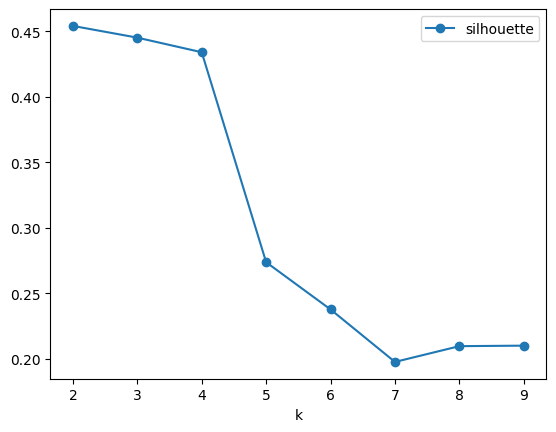

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

seed = 42

def find_optimal_k(data):
    # 1. Preprocesar UNA sola vez (usa tu preprocessor ya definido)
    X_proc = preprocessor.fit_transform(data)

    scores = []
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=seed)
        labels = kmeans.fit_predict(X_proc)

        # 2. Silhouette sobre los datos NUMÉRICOS preprocesados
        score = silhouette_score(X_proc, labels)
        scores.append((k, score))

    best_k = max(scores, key=lambda x: x[1])[0]
    return best_k, scores

best_k, all_scores = find_optimal_k(data_model)
df_out = pd.DataFrame(all_scores, columns=['k', 'silhouette'])
display(df_out)
df_out.plot(x='k', y='silhouette', marker='o')

    k  silhouette_pca
0   2        0.611712
1   3        0.528453
2   4        0.647741
3   5        0.709759
4   6        0.691022
5   7        0.707541
6   8        0.712847
7   9        0.687740
8  10        0.692996


<Axes: xlabel='k'>

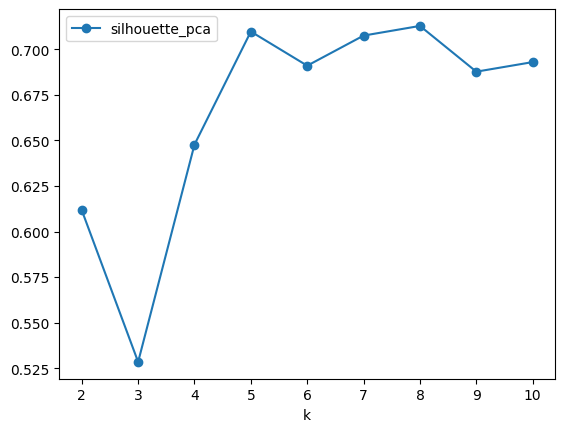

In [16]:

def evaluate_k_with_pca(X, preprocessor, n_components=2, k_min=2, k_max=10, random_state=42):
    X_proc = preprocessor.fit_transform(X)
    pca = PCA(n_components=n_components, random_state=random_state)
    X_pca = pca.fit_transform(X_proc)

    results = []
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X_pca)

        sil = silhouette_score(X_pca, labels)
        results.append({"k": k, "silhouette_pca": sil})

    return pd.DataFrame(results)

df_pca_scores = evaluate_k_with_pca(data_model, preprocessor)
print(df_pca_scores)
df_pca_scores.plot(x='k', y='silhouette_pca', marker='o')

In [17]:
# ASIGNAR GRUPOS CON K-MEANS
best_k = 5 # Mejor k obtenido previamente
kmeans_final = KMeans(n_clusters=best_k, random_state=seed)
X_final = preprocessor.fit_transform(data_model)
pca = PCA(n_components=2, random_state=seed)
X_pca = pca.fit_transform(X_final)
labels_final = kmeans_final.fit_predict(X_pca)

In [18]:
print("Shape después de PCA:", X_pca.shape)
print("Vector con los porcentajes de varianza que explica cada componente principal:", pca.explained_variance_ratio_)

Shape después de PCA: (300, 2)
Vector con los porcentajes de varianza que explica cada componente principal: [0.55702517 0.19784222]


In [19]:
# Crear DataFrame con loadings
n_components = pca.n_components_
loadings = pca.components_.T
feature_names = preprocessor.get_feature_names_out()

loadings_df = pd.DataFrame(loadings,columns=[f'PC{i+1}' for i in range(n_components)],index=feature_names)

loadings_df
print(loadings_df)

                                                      PC1       PC2
num__Edad                                       -0.010623 -0.002519
num__Meld_Score                                  0.023777  0.017347
num__Días_En_UCI_Pre_Tx                         -0.013383  0.077680
num__Tiempo_Isquemia_Fria                        0.004456 -0.056549
num__Tiempo_Isquemia_caliente                   -0.000895 -0.025108
num__Tiempo_Cx                                  -0.010821 -0.019250
num__Días_Tratamiento_Antibiótico_Previo_A_Tx#1 -0.001144  0.002664
num__Nutrición_Enteral                          -0.006653  0.006862
num__Días_Nutrición_Enteral                     -0.008124  0.013134
num__Complicaciones_Técnicas                     0.004070 -0.013598
cat__Etiología_#1                                0.998453  0.029102
cat__Etiología_#2                               -0.003888 -0.008264
cat__Sexo                                       -0.028601 -0.008992
cat__Diabetes_Mellitus                          

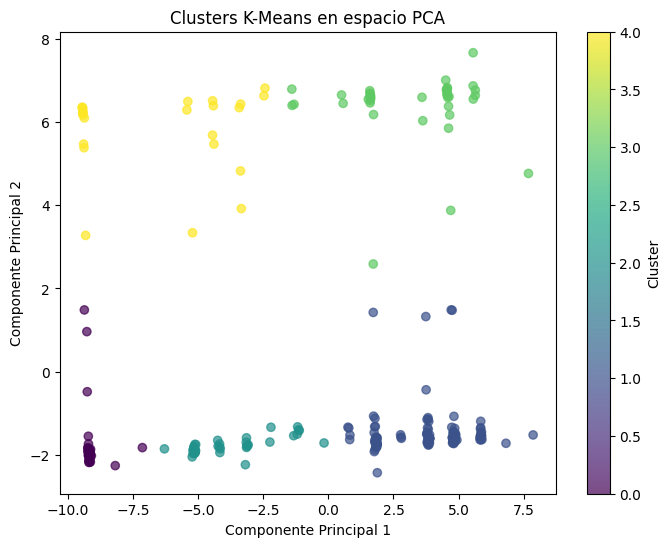

In [20]:
# grafica cluster
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_final, cmap='viridis', alpha=0.7)
plt.title('Clusters K-Means en espacio PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [21]:
df_predictions = data.copy()
df_predictions["Cluster"] = np.nan
df_predictions.loc[data_model.index, 'Cluster'] = labels_final
df_predictions

,Código anonimizado,#Paciente_Tx,Etiología_#1,Etiología_#2,Edad,Sexo,Child_Pugh_Score_Cat,Child_Pugh_Score,Meld_Score,Diabetes_Mellitus,...,Requerimiento_de_diálisis,Trasfusión_GRE_hasta_1m_POP,Reintervención_Quirúrgica_hasta_1m_POP,Retrasplante,Vivo_Hoy,Fecha_Control/Muerte,SOBREVIDA_DIAS,SOBREVIDA_MESES,SOBREVIDA_AÑOS,Cluster
0,P001,1,HCV,NINGUNA,62,M,NaN,-1,18,NO,...,NO,NO,SI,NO,NO,2009-10-05,275,9.17,0.76,NaN
1,P002,2,NASH,NINGUNA,62,M,NaN,-1,17,NO,...,NO,NO,SI,NO,NO,2009-01-11,1,0.03,0.00,NaN
2,P003,3,HEPATITIS AUTOINMNE,NINGUNA,56,F,NaN,-1,15,NO,...,NO,NO,NO,NO,SI,2023-12-31,5444,181.47,15.12,NaN
3,P004,4,NASH,NINGUNA,58,M,NaN,-1,9,NO,...,NO,NO,NO,NO,SI,2023-12-31,5442,181.40,15.12,NaN
4,P005,5,ALCOHÓLICA,NINGUNA,62,F,NaN,-1,22,SI,...,NO,NO,NO,NO,SI,2023-12-31,4724,157.47,13.12,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,P553,553,CRIPTOGENICA,NINGUNA,22,M,C,11,22,NO,...,NO,NO,NO,NO,SI,2024-09-21,0,0.00,0.00,NaN
553,P554,554,HEPATITIS AUTOINMNE,NINGUNA,33,F,C,10,21,NO,...,SI,SI,DESCONOCIDO,DESCONOCIDO,NO,2025-03-31,174,5.00,0.00,NaN
554,P555,555,NASH,ALCOHÓLICA,55,M,B,9,20,SI,...,NO,NO,NO,NO,SI,2025-05-07,203,6.00,0.00,NaN
555,P556,556,CIRROSIS HEPATICA POR COLANGIOPATÍA AUTOINMUNE,NINGUNA,54,F,B,9,14,NO,...,NO,NO,NO,NO,SI,2025-05-13,196,6.00,0.00,NaN


In [22]:
num_cols = df_predictions.select_dtypes(include="number").columns.drop("Cluster")

means = df_predictions.groupby("Cluster")[num_cols].mean()
medians = df_predictions.groupby("Cluster")[num_cols].median()

display(means.head())     # en notebook
display(medians.head())

,#Paciente_Tx,Edad,Child_Pugh_Score,Meld_Score,Peso_previo_Cx,Talla,IMC,Año_Tx,Días_Totales_Intrahospitalarios_Pre_Tx,Días_En_UCI_Pre_Tx,...,Nutrición_Enteral,Días_Nutrición_Enteral,Complicaciones_Técnicas,Dias_Estancia_Hospitalaria,Días_En_UCI_Post_Tx,Días_En_Hospitalización_Piso_Post_Tx,Días_Totales_Intrahospitalarios_Post_Tx,SOBREVIDA_DIAS,SOBREVIDA_MESES,SOBREVIDA_AÑOS
Cluster,,,,,,,,,,,,,,,,,,,,,
0.0,215.111111,57.733333,-0.555556,14.377778,44.088889,106.066667,15.828667,2014.088889,-0.155556,555.688889,...,0.044444,0.288889,0.266667,12.533333,3.422222,8.177778,9.755556,2358.888889,78.629111,6.553333
1.0,227.326923,55.852564,0.756410,16.519231,36.814103,83.275641,12.797436,2014.346154,0.346154,550.814103,...,0.032051,0.243590,0.288462,13.692308,2.826923,9.269231,11.192308,2554.955128,85.155705,7.090769
2.0,217.108108,53.270270,0.486486,16.243243,28.297297,62.756757,8.634595,2014.108108,1.486486,365.675676,...,0.081081,1.243243,0.297297,14.027027,3.081081,7.702703,9.459459,2434.594595,81.122703,6.742162
3.0,304.710526,54.421053,1.263158,17.657895,53.526316,130.789474,20.436579,2016.526316,0.342105,751.868421,...,0.078947,0.973684,0.236842,15.552632,2.815789,8.052632,9.500000,1744.657895,58.139211,4.829737
4.0,347.333333,57.000000,1.333333,15.916667,52.666667,135.333333,20.575417,2017.500000,-0.750000,2148.416667,...,0.000000,0.000000,0.250000,12.333333,1.750000,7.250000,7.375000,2150.583333,71.625000,5.930417


,#Paciente_Tx,Edad,Child_Pugh_Score,Meld_Score,Peso_previo_Cx,Talla,IMC,Año_Tx,Días_Totales_Intrahospitalarios_Pre_Tx,Días_En_UCI_Pre_Tx,...,Nutrición_Enteral,Días_Nutrición_Enteral,Complicaciones_Técnicas,Dias_Estancia_Hospitalaria,Días_En_UCI_Post_Tx,Días_En_Hospitalización_Piso_Post_Tx,Días_Totales_Intrahospitalarios_Post_Tx,SOBREVIDA_DIAS,SOBREVIDA_MESES,SOBREVIDA_AÑOS
Cluster,,,,,,,,,,,,,,,,,,,,,
0.0,195.0,61.0,-1.0,13.0,65.0,162.0,24.220,2014.0,-1.0,0.0,...,0.0,0.0,0.0,10.0,2.0,6.0,8.0,2481.0,82.700,6.890
1.0,199.5,60.5,-1.0,15.0,51.5,145.5,18.860,2014.0,-1.0,0.0,...,0.0,0.0,0.0,10.0,2.0,7.0,9.0,2430.5,81.015,6.750
2.0,193.0,57.0,-1.0,16.0,-1.0,-1.0,-1.000,2014.0,-1.0,0.0,...,0.0,0.0,0.0,10.0,2.0,8.0,8.0,2399.0,79.970,6.660
3.0,302.0,60.5,-1.0,16.5,59.0,156.5,23.045,2016.5,-1.0,0.0,...,0.0,0.0,0.0,10.0,1.0,7.0,7.5,2034.5,67.815,5.650
4.0,366.5,60.0,-1.0,15.5,62.0,160.5,22.935,2018.0,-1.0,1911.5,...,0.0,0.0,0.0,10.0,2.0,5.5,7.0,2101.0,70.030,5.835


In [23]:
global_mean = df_predictions[num_cols].mean()
global_std  = df_predictions[num_cols].std(ddof=0).replace(0, np.nan)
sizes = df_predictions['Cluster'].value_counts().sort_index()

z = (means - global_mean) / global_std  # z-score de la media del cluster vs global

TOP = 10
for c in z.index:
    top_high = z.loc[c].sort_values(ascending=False).head(TOP)
    top_low  = z.loc[c].sort_values(ascending=True).head(TOP)

    print(f"\n=== Cluster {c} (n={sizes.loc[c]}) ===")
    print("↑ Variables más altas vs global (z):")
    print(top_high.round(2).to_string())
    print("↓ Variables más bajas vs global (z):")
    print(top_low.round(2).to_string())


=== Cluster 0.0 (n=45) ===
↑ Variables más altas vs global (z):
Tiempo_Isquemia_Fria        0.55
Tiempo_Cx                   0.43
Tiempo_Isquemia_caliente    0.40
Talla                       0.32
Peso_previo_Cx              0.26
IMC                         0.25
Edad                        0.14
SOBREVIDA_AÑOS              0.10
SOBREVIDA_MESES             0.09
SOBREVIDA_DIAS              0.09
↓ Variables más bajas vs global (z):
Child_Pugh_Score                             -0.50
Año_Tx                                       -0.41
#Paciente_Tx                                 -0.40
Meld_Score                                   -0.25
Días_Nutrición_Enteral                       -0.15
Tiempo_De_Dosis_Hasta_Tx#1                   -0.14
Días_Tratamiento_Antibiótico_Previo_A_Tx#1   -0.12
Nutrición_Enteral                            -0.08
Días_Totales_Intrahospitalarios_Post_Tx      -0.07
Días_Totales_Intrahospitalarios_Pre_Tx       -0.05

=== Cluster 1.0 (n=156) ===
↑ Variables más altas vs glob

In [24]:
pipe = make_pipeline(
    preprocessor,
    PCA(n_components=2, random_state=seed),
    KMeans(n_clusters=best_k, random_state=seed)
)
# guardar el pipeline
import joblib
import os
os.makedirs('../models', exist_ok=True)
joblib.dump(pipe, '../models/kmeans_pipeline.pkl')

['../models/kmeans_pipeline.pkl']